##  Calculate exceedance probabilities of extreme water levels for NC barrier islands -

The purpose of this notebook is to calculate exceedance probabilities of extreme water levels for Downeast using a GEV approach. The parameters (scale, shape, and location) for the closest NOAA CO-OPS (Center for Operational Oceanographic Products and Services) station to each barrier island were extracted from the NOAA Technical Report NOS CO-OPS 067 (Zervas, 2013) available in https://tidesandcurrents.noaa.gov/publications/NOAA_Technical_Report_NOS_COOPS_067a.pdf

In [1]:
### Packages

from pathlib import Path
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import os
from shapely.geometry import Point

import numpy as np

from scipy.stats import genextreme

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
### Set working directory

path='..' # introduce path to your working directory
os.chdir(path)

### Merge all barrier polygons in one single shp 

# Create folder if it does no exist
outdir= './data/Exceedance'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Read all shp and merge them in one single dataset
folder = Path("./data/Oriental")
shapefiles = folder.glob("*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)

# For some barrier islands, the column "name" has a different format. Convert name to same format so they can be matched later
# gdf.loc[gdf.name == 'NC1   -           Core        Banks', 'name'] = 'NC1'
# gdf.loc[gdf.name == 'NC2-        Cape     Lookout, NC', 'name'] = 'NC2'
# gdf.loc[gdf.name == 'NC3  ShacklefordBanks,     NC', 'name'] = 'NC3'
# gdf.loc[gdf.name == 'NC4-        Bogue    Banks,   NC', 'name'] = 'NC4'
# gdf.loc[gdf.name == 'NC12Ocracoke  Island,   NC', 'name'] = 'NC12'


gdf.to_file('./data/Exceedance/Oriental.shp')

In [3]:
barriers= gpd.read_file('./data/Exceedance/Oriental.shp')
barriers

,id,geometry
0,None,"POLYGON ((-76.66499 35.16614, -76.59747 35.176..."


In [4]:
### Read stations.csv and convert to geodataframe 

df = pd.read_csv("./data/tables/Stations.csv", sep=",", header=0) 
df["geometry"] = df[["Longitude", "Latitude"]].apply(Point, axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf.to_file("./data/Exceedance/Stations.shp")

/home/ebgoldstein/anaconda3/envs/roads/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/tmp/ipykernel_29340/3457588174.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("./data/Exceedance/Stations.shp")


In [5]:
### Find nearest station to each barrier and its corresponding distance 

barriers= gpd.read_file('./data/Exceedance/Oriental.shp')
stations= gpd.read_file('./data/Exceedance/Stations.shp')

barriers= barriers.to_crs('esri:102009')
stations= stations.to_crs('esri:102009')

print(barriers)

barrier_id=[]
min_distance=[]
station_number=[]

for i in range(0,len(barriers)):
    name= barriers['id'][i]
    barrier_id.append(name)
    barrier= barriers['geometry'][i]
    barrier= gpd.GeoSeries(barrier)
    distance=[]
    for j in range(0,len(stations)):
        station= stations['geometry'][j]
        station= gpd.GeoSeries(station)
        dist = barrier.distance(station)
        dist = dist.iloc[0]
        distance.append(dist)
        
    min_dist= min(distance)
    pos=[e for e, f in enumerate(distance) if f == min_dist]
    distance_km=min_dist/1000
    min_distance.append(distance_km)
    station_nu=stations.Station[pos]
    station_nu=station_nu.iloc[0]
    station_number.append(station_nu)
    
df = pd.DataFrame(list(zip(barrier_id, station_number, min_distance)),
               columns =['id', 'closest_station','distance_km'])
print(df)
print(barriers)
df2  = barriers.merge(df, on='id', how='left')
gdf = gpd.GeoDataFrame(df2)
gdf.to_file("./data/Exceedance/Oriental_Stations.shp")

     id                                           geometry
0  None  POLYGON ((1649494.316 -321374.161, 1654915.349...
     id  closest_station  distance_km
0  None          8656483    26.217266
     id                                           geometry
0  None  POLYGON ((1649494.316 -321374.161, 1654915.349...


/tmp/ipykernel_29340/3238782909.py:42: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("./data/Exceedance/Oriental_Stations.shp")


     id  closest_st  distance_k  \
0  None     8656483   26.217266   

                                            geometry  
0  POLYGON ((1649494.316 -321374.161, 1654915.349...  
0.56


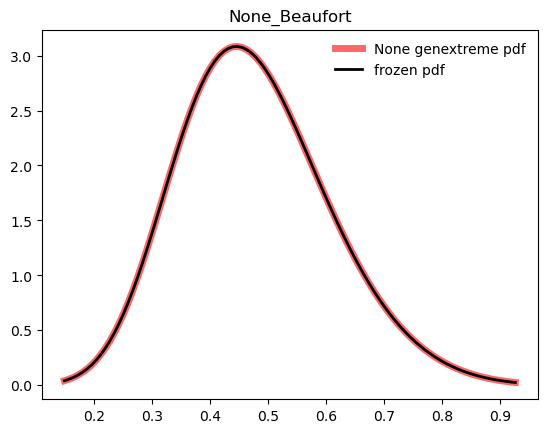

/tmp/ipykernel_29340/1625106639.py:95: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim = (0,150)) # set x axis limits


In [6]:
### Calculate exceedance probability curves 

# Create folder if it does no exist
outdir= './data/Exceedance/PDF'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Create folder if it does no exist
outdir= './data/Exceedance/Probability'
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
# Create folder if it does no exist
outdir= './data/Exceedance/Curves'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Load required data (.csv file available in GitHub, see "Data" folder)
param = pd.read_csv("./data/tables/Parameters.csv", sep=",", header=0) # table with parameters from NOAA's report 
stations = pd.read_csv("./data/tables/Stations.csv", sep=",", header=0) # table with station information, including MLR trends (used to detrend historical data)
mhhw = pd.read_csv("./data/tables/MHHW.csv", sep=",", header=0) # table with MHHW only for stations linked to the barriers islands (info extracted from https://tidesandcurrents.noaa.gov/est/)
barriers = gpd.read_file("./data/Exceedance/Oriental_Stations.shp") # shp with Gulf and Atlantic US barriers. Code of closest station and distance to it included as attributes

print(barriers)
# Loop within US barriers shp to calculate exceedance for each barrier, using parameters from the closest station
for i in range(0, len(barriers)):
    barrier= barriers['id'][i]
    station= barriers['closest_st'][i]
    
    for j in range(0, len(param)):
        if param.Station_Number[j]==station:
            c=float(param.Shape_meters[j]) # shape parameter
            loc=float(param.Location_meters[j]) # location parameter
            scale=float(param.Scale_meters[j]) # scale parameter
        else:
            continue
    
    for k in range(0,len(stations)):
        if stations.Station[k]==station:
            MSL_trend=float(stations.MSL_Trend[k]) # retrieve MSL trend of that station (in mm)
            station_name=stations.Station_Name[k]  
        else:
            pass
    
    for l in range(0,len(mhhw)):
        if mhhw.Station[l]==station:
            MHHW=mhhw.MHHW[l] # retrieve the local MHHW (in m)
            print(MHHW)
        else:
            pass
    
    # plot probability distribution function
    fig, ax = plt.subplots(1, 1)

    x = np.linspace(genextreme.ppf(0.001, c, loc, scale), genextreme.ppf(0.999, c, loc, scale), 100)
    ax.plot(x, genextreme.pdf(x, c, loc, scale), 'r-', lw=5, alpha=0.6, label='{0} genextreme pdf'.format(barrier, station_name))
    rv = genextreme(c, loc, scale)
    ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
    
    vals = genextreme.ppf([0.001, 0.5, 0.999], c, loc, scale)
    np.allclose([0.001, 0.5, 0.999], genextreme.cdf(vals, c, loc, scale))

    r = genextreme.rvs(c, loc, scale, size=1000) # sample from the distribution to get water hts > MHHW
    ax.legend(loc='best', frameon=False)
    plt.title(label='{0}_{1}'.format(barrier, station_name))
    plt.show() 
    fig.savefig('./data/Exceedance/PDF/{0}.png'.format(barrier), dpi=500, facecolor='w')
    plt.close("all")
       
    # calculate exceedance probabilities and return periods
    n = len(r) # total observations
    df = pd.DataFrame() # initialise dataframe
    samples_sorted = list(sorted(r)) # sort 'r' observations ascending
    rank = list(range(1, 1 + n)) # rank from 1:n, smallest first
    df['Rank'] = rank # make 'Rank' a column of the dataframe (for easier plotting later)
    prob = ((n - df['Rank'] + 1) / (n + 1)) # calculate probability
    return_years = (1 / prob) # calculate return period (in years) 
    trend = [x*(MSL_trend/1000) for x in return_years] # calculate linear background trend in MHW (convert MSL_trend to meters)
    MaxWL = [x + y for x, y in zip(trend, samples_sorted)] # add trend to >MHHW samples from GEV
    MaxWL = [x + MHHW for x in MaxWL] # for real total water level, add background MHHW level

    # fill out remaining columns of dataframe (for easier plotting)
    df['MaxWL'] = MaxWL
    df['Probability'] = prob
    df['Return_Pd'] = return_years
    df.to_csv("./data/Exceedance/Probability/{0}_Exceedance.csv".format(barrier)) # save data in csv
    
    # plot exceedance probability curves
    sns.set_theme()
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ax.set(xscale="log")
    ax.tick_params(left=True, bottom=True)
    ax = sns.scatterplot(x="Return_Pd", y="MaxWL", data=df, color= 'r', linewidth=0, s= 25, label='exceedance probability')
    ax.set(xlim = (0,150)) # set x axis limits
    a =list(df.loc[df['Rank'] == 991, 'MaxWL'])[0] # to find upper limit of y axis
    ax.set(ylim = (0, a+0.5)) # set y axis limits
    ax.legend(loc='best', frameon=False)
    plt.title(label='{0}_{1}'.format(barrier, station_name))
    plt.savefig("./data/Exceedance/Curves/{0}.png".format(barrier), dpi=500, facecolor='w')
    plt.close("all")